In [32]:
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

In [33]:
input_filename = 'data/yields.parquet'
# load the data into a dataframe
df = pd.read_parquet(input_filename)
# df.head()

In [62]:
grouped_df = df.groupby(['time', 'County','year']).agg({'ndvi.landsat': 'mean', 'Yield (Bu/Acre)': 'mean', 'Acres Planted':'mean'}).reset_index()
print(f'Number of rows in df: {len(df):,}')
print(f'Number of rows in grouped_df: {len(grouped_df):,}')
grouped_df.head()

Number of rows in df: 8,401,661
Number of rows in grouped_df: 776,522


,time,County,year,ndvi.landsat,Yield (Bu/Acre),Acres Planted
0,2013-03-18,COLORADO/ADAMS,2013,0.303621,27.5,153000.0
1,2013-03-18,COLORADO/MORGAN,2013,0.272985,36.5,55800.0
2,2013-03-18,COLORADO/WELD,2013,0.202855,29.5,134500.0
3,2013-03-18,NEBRASKA/BANNER,2013,0.198277,23.2,58200.0
4,2013-03-18,NEBRASKA/BOX BUTTE,2013,0.259546,51.2,110600.0


In [63]:
CUT_OFF_MONTH = 6 # use no data after June 30
YEARS_CUT_OFF = 4 # <
R_CUT_OFF = 0.0 # >
grouped_df1 = grouped_df[(grouped_df['time'].dt.month < CUT_OFF_MONTH)]
max_ndvi_idx = grouped_df1.groupby(['County','year'])['ndvi.landsat'].idxmax()
max_ndvi_df = grouped_df1.loc[max_ndvi_idx, ['year','County','ndvi.landsat', 'Yield (Bu/Acre)', 'Acres Planted']]

In [64]:
def getR2(county):
    y = max_ndvi_df[max_ndvi_df['County'] == county]
    X = sm.add_constant(y['ndvi.landsat'])
    model = sm.OLS(y['Yield (Bu/Acre)'], X)
    results = model.fit()
    return results.rsquared

In [65]:
counties = max_ndvi_df['County'].unique()
good_counties = []
for county in counties:
    row_count = max_ndvi_df[max_ndvi_df['County'] == county].shape[0]
    if row_count < YEARS_CUT_OFF:
        continue
#     print(row_count)
    r2 = getR2(county)
    if r2 > R_CUT_OFF:
        good_counties.append(county)
        # print(f'{county}: {r2}')

# len(good_counties) 

In [66]:
subset_df = max_ndvi_df[max_ndvi_df['County'].isin(good_counties)]

In [67]:
def do_county(county):
    y = max_ndvi_df[max_ndvi_df['County'] == county]
    # Perform linear regression
    X = sm.add_constant(y['ndvi.landsat'])
    model = sm.OLS(y['Yield (Bu/Acre)'], X)
    results = model.fit()
    # Create a new DataFrame with additional columns
    new_df = y.copy()
    new_df['alpha'] = results.params[0]
    new_df['beta'] = results.params[1]
    new_df['r2'] = results.rsquared
    new_df['fitted'] = results.params[0] + results.params[1] * new_df['ndvi.landsat']
    new_df['error'] = new_df['fitted'] - new_df['Yield (Bu/Acre)']
    return new_df


x = []
for county in good_counties:
    x.append(do_county(county))

final = pd.concat(x)
sum(final['error'])

1.3677947663381929e-12

In [68]:
final['actual_harvest'] = final['Acres Planted'] * final['Yield (Bu/Acre)']
final['fitted_harvest'] = final['Acres Planted'] * final['fitted']
# final.head()

grouped_final = final.groupby(['year']).agg({'actual_harvest':'sum', 'fitted_harvest':'sum', 'Acres Planted':'sum'})
grouped_final['actual_yield'] = grouped_final['actual_harvest'] / grouped_final['Acres Planted']
grouped_final['fitted_yield'] = grouped_final['fitted_harvest'] / grouped_final['Acres Planted']
grouped_final['error'] = grouped_final['fitted_yield'] - grouped_final['actual_yield']
grouped_final['%error'] = grouped_final['error'] / grouped_final['actual_yield'] * 100.0

print(f'MAPE: {grouped_final["%error"].abs().mean()}')
print(f'RMS: {np.sqrt(np.mean(grouped_final["error"] ** 2))}')
# grouped_final.head(12)
# show the dataframe with human readable numbers
grouped_final.style.format('{:,.1f}')

MAPE: 6.446881399387081
RMS: 2.9194788276527905


,actual_harvest,fitted_harvest,Acres Planted,actual_yield,fitted_yield,error,%error
year,,,,,,,
2013,"914,855,390.0","956,585,785.7","24,448,800.0",37.4,39.1,1.7,4.6
2014,"847,974,010.0","960,367,438.9","26,014,400.0",32.6,36.9,4.3,13.3
2015,"939,302,090.0","1,060,849,747.7","25,529,600.0",36.8,41.6,4.8,12.9
2016,"1,173,857,580.0","1,093,165,458.8","23,376,500.0",50.2,46.8,-3.5,-6.9
2017,"886,976,530.0","868,087,822.1","19,755,100.0",44.9,43.9,-1.0,-2.1
2018,"774,187,890.0","759,805,012.9","18,520,700.0",41.8,41.0,-0.8,-1.9
2019,"871,443,340.0","810,759,091.7","17,917,700.0",48.6,45.2,-3.4,-7.0
2020,"987,388,110.0","925,243,057.3","21,734,700.0",45.4,42.6,-2.9,-6.3
2021,"828,911,710.0","784,477,374.2","19,502,700.0",42.5,40.2,-2.3,-5.4


In [69]:
varE = grouped_final['error'].var()
varY = grouped_final['actual_yield'].var()
R2 = 1 - varE / varY
# print R2 in human readable
print(f'R2: {R2:.2f}')
# print the std err
print(f'std err: {np.sqrt(varE):.2f}')

R2: 0.69
std err: 3.07


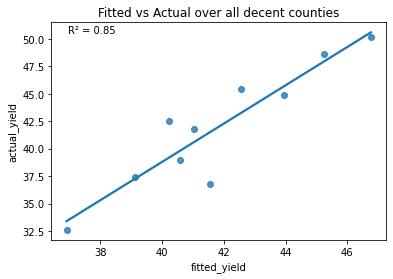

In [70]:
sns.regplot(x='fitted_yield', y='actual_yield', data=grouped_final,ci=None)
plt.annotate(f"R² = {round(grouped_final['actual_yield'].corr(grouped_final['fitted_yield'])**2, 2)}", xy=(0.05, 0.95), xycoords='axes fraction')
plt.title(f'Fitted vs Actual over all decent counties')
plt.show()

https://static.cambridge.org/binary/version/id/urn:cambridge.org:id:binary:20201222160953312-0066:S1074070820000188:S1074070820000188_tab3.png